In [425]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from cvxopt import matrix, solvers
import scipy
from scipy.optimize import LinearConstraint
from scipy.optimize import NonlinearConstraint
from scipy.optimize import Bounds

# Problem 3

(b)

In [277]:
sigma = 0.25
v0 = 0.05**2 
k = 1
rho = -0.5
theta = 0.1
q = 0
r = 0
T = 3/12
S0 = 100
K = 100

In [661]:
def simulation(sigma=0.25, v0=0.05**2, k=1, rho=-0.5, theta=0.1, q=0, r=0, S0=100, T=3/12, dt=1/252, paths=10000):
    steps = round(T/dt)
    S = np.zeros((steps + 1, paths))
    S[0] = S0
    v = np.zeros((steps + 1, paths))
    v[0] = v0
    N = paths
    for t in range(1, steps + 1):
        z1 = np.random.standard_normal(N)
        z2 = np.random.standard_normal(N)
        x1 = 0 + np.sqrt(dt)*z1
        x2 = 0 + np.sqrt(dt)*(rho*z1 + np.sqrt(1-rho**2)*z2)
        #v[t] = np.abs(v[t-1] + k*(theta-v[t-1])*dt + sigma*np.sqrt(v[t-1])*x2) # Reflect
        S[t] = S[t-1] + (r-q)*S[t-1]*dt + np.sqrt(v[t-1])*S[t-1]*x1
        v[t] = np.maximum(v[t-1] + k*(theta-v[t-1])*dt + sigma*np.sqrt(v[t-1])*x2,0) # Truncate
#     X = np.linspace(0, 1, steps + 1, endpoint=True)
#     for i in range(N):
#         plt.plot(X, S[:, i])
#     plt.show()
    Mean = [np.mean(S[:,i]) for i in range(N)]
    return S,Mean

In [662]:
S,Mean = simulation(sigma=sigma,v0=v0,k=k,rho=rho,q=q,r=r,S0=S0)

In [663]:
def calc_simulated_price(r,T,Mean,K):
    payoff = np.maximum(np.array(Mean) - K,0)
    return np.exp(-(r+q)*T) * np.mean(payoff)

In [664]:
c0 = calc_simulated_price(r,T,Mean,K)
print(c0)

1.0138999365397987


(c)

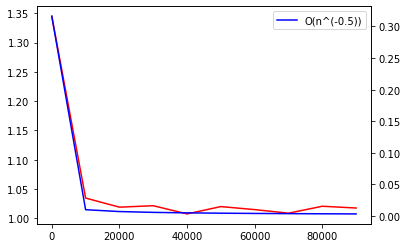

In [707]:
N = np.arange(10,100000,10000)
c = []
On12 = []
j = 0
for n in N:
    S,Mean = simulation(paths=n)
    c0 = calc_simulated_price(r,T,Mean,K)
    n12 = n**(-1/2)
    c.append(c0)
    On12.append(n12)

f = plt.figure()
ax1 = f.add_subplot(111)
ax1.plot(N,c,color='red')
ax2 = ax1.twinx()
ax2.plot(N,On12,label = 'O(n^(-0.5))',color='blue')
ax2.legend()
plt.show()

(e)(f)

-0.3632924378000122
-0.3263271241437427
-0.3795541091243455
-0.37064970734282404
-0.3338708746170619
-0.3542277039184429
-0.3753974550342349
-0.37211194821254223
-0.38294895692748016
-0.32744890041664276


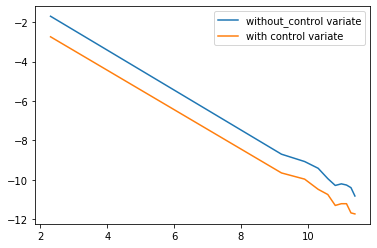

In [800]:
Theta = []
Theta_hat = []
N = np.arange(10,100000,10000)
times = 100
theta = []
z = []
for n in N:
    for i in range(times):
        S,Mean = simulation(sigma=sigma,v0=v0,k=k,rho=rho,q=q,r=r,S0=S0,T=T,paths=n)
        hx = np.maximum(np.array(Mean) - K,0)
        theta += [np.mean(hx)]
        euro_call = np.mean(np.maximum(S[-1] - K,0))
        z += [euro_call]
    c = -np.cov(theta,z)[0][1]/np.var(z)
    print(c)
    theta_hat = theta + c*(z-np.mean(z))
    Theta.append(np.var(theta))
    Theta_hat.append(np.var(theta_hat))
    theta.clear()
    z.clear()
plt.plot(np.log(N),np.log(Theta),label='without_control variate')
plt.plot(np.log(N),np.log(Theta_hat),label='with control variate')
plt.legend()
plt.show()

# problem 4

(a)

In [573]:
def mini_cov(w):
    R = pd.read_csv('DataForProblem4.csv')
    Ra = (R.iloc[:,1:11])
    C = (Ra.cov()).values
    return 10000*np.dot(w.T,np.dot(w,C))

In [755]:
x0 = [0]*10
A = np.ones(10)
L = [0]*10
U = [1]*10
bounds = Bounds(L,U)
linear_constraint = LinearConstraint(A,[1],[1])
w1 = scipy.optimize.minimize(mini_cov, x0,constraints=[linear_constraint],bounds=bounds)
print(w1)

     fun: 2.5958372394509026
     jac: array([6.75720727, 6.07175142, 5.19168067, 5.19164351, 5.76115251,
       5.97964203, 5.19167614, 6.49590385, 6.58530408, 5.90947104])
 message: 'Optimization terminated successfully.'
    nfev: 86
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([0.00000000e+00, 0.00000000e+00, 6.90558741e-01, 1.45166955e-01,
       0.00000000e+00, 2.60500946e-16, 1.64274304e-01, 0.00000000e+00,
       3.84164112e-16, 6.40586973e-17])


(b)

In [767]:
def optimal_port(w):
    a = 0.5
    R = pd.read_csv('DataForProblem4.csv')
    Ra = (R.iloc[:,1:11])
    R_mean = list(Ra.mean())
    C = (Ra.cov()).values
    sum = np.dot(R_mean,w) - a*np.dot(np.dot(w,C),w)
    return -sum*100000

In [768]:
x0 = [0.1]*10
A = np.ones(10)
L = [0]*10
U = [1]*10
bounds = Bounds(L,U)
linear_constraint = LinearConstraint(A,[1],[1])
w2 = scipy.optimize.minimize(optimal_port, x0,constraints=[linear_constraint],bounds=bounds)
print(w2)

     fun: -15.887551348647827
     jac: array([131.49230254,  44.58721924,   8.61148071, 110.11176944,
       131.99401987, 138.2733531 ,  34.12223196,   8.61147678,
       299.6663003 , 101.13594615])
 message: 'Optimization terminated successfully.'
    nfev: 37
     nit: 3
    njev: 3
  status: 0
 success: True
       x: array([5.83379449e-11, 1.27352440e-10, 3.39517720e-02, 1.50836323e-11,
       6.17341418e-11, 7.33604935e-11, 8.68934170e-11, 9.66048228e-01,
       3.91508037e-10, 2.22042324e-13])


(c)

In [732]:
def max_return(w):
    R = pd.read_csv('DataForProblem4.csv')
    Ra = (R.iloc[:,1:11])
    R_mean = list(Ra.mean())
    ER = np.dot(R_mean,w)
    return -ER*100000

In [733]:
def cons_f(w):
    A = np.ones(10)
    return np.dot(A,w)

In [734]:
x0 = [0.1]*10
L = [0]*10
U = [1]*10
bounds = Bounds(L,U)
#linear_constraint = LinearConstraint(A,[1],[1])
nonlinear_constraint = NonlinearConstraint(cons_f, 0, 1)
w3 = scipy.optimize.minimize(max_return, x0,constraints=[nonlinear_constraint],bounds=bounds)
print(w3)

     fun: -41.0358556803067
     jac: array([ 83.26693249,   9.56175327, -21.91235065,  71.71314764,
        91.63346624,  95.61752987,   0.        , -41.03585672,
       249.80079699,  60.15936279])
 message: 'Optimization terminated successfully.'
    nfev: 24
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([7.63057534e-10, 8.67185490e-11, 0.00000000e+00, 6.58138793e-10,
       8.40961439e-10, 8.76161727e-10, 0.00000000e+00, 1.00000000e+00,
       2.29278499e-09, 5.51081319e-10])


(d)

In [809]:
def bench_track(w):
    R = pd.read_csv('DataForProblem4.csv')
    Ra = (R.iloc[:,1:11])
    bench = R.loc[:,'B1']
    e = np.sum((np.dot(Ra,w) - bench)**2)
    return e*10000

In [810]:
x0 = [0.1]*10
A = np.ones(10)
L = [0]*10
U = [1]*10
bounds = Bounds(L,U)
linear_constraint = LinearConstraint(A,[1],[1])
w4 = scipy.optimize.minimize(bench_track, x0,constraints=[linear_constraint],bounds=bounds)
print(w4)

     fun: 3.3627411398690223
     jac: array([25.76840311, 26.52925101, 25.76117796, 25.76553717, 25.7639178 ,
       25.76318869, 25.76403967, 25.76897994, 25.7651464 , 25.90629512])
 message: 'Optimization terminated successfully.'
    nfev: 191
     nit: 15
    njev: 15
  status: 0
 success: True
       x: array([7.04710124e-02, 5.65411433e-17, 1.58304419e-01, 1.94541523e-01,
       5.37296588e-03, 1.03906124e-01, 1.77528454e-01, 2.37800530e-01,
       5.20749721e-02, 0.00000000e+00])


(f)

In [817]:
def log_utility(w):
    R = pd.read_csv('DataForProblem4.csv')
    Ra = (R.iloc[:,1:11])
    col_name = Ra.columns.tolist()
    Ra.insert(col_name.index('Sec1'),'Cash',0)
    Ra = Ra + 1
    return 10000*(-np.sum(np.log(np.dot(Ra,w)))/Ra.shape[0])

In [818]:
x0 = [1/11]*11
A = np.ones(11)
L = [0]*11
U = [1]*11
bounds = Bounds(L,U)
linear_constraint = LinearConstraint(A,[1],[1])
w4 = scipy.optimize.minimize(log_utility, x0,constraints=[linear_constraint],bounds=bounds)
print(w4)

     fun: -1.6680001087804834
     jac: array([ -9999.99894291,  -9987.69343472,  -9996.16698073,  -9999.69903819,
        -9989.62855551,  -9987.4999761 ,  -9986.91097717,  -9997.18909985,
       -10000.00015673,  -9970.86891997,  -9990.5977011 ])
 message: 'Optimization terminated successfully.'
    nfev: 40
     nit: 3
    njev: 3
  status: 0
 success: True
       x: array([1.91044647e-01, 9.16185704e-14, 0.00000000e+00, 0.00000000e+00,
       2.80984107e-13, 1.86449460e-13, 1.99525110e-13, 0.00000000e+00,
       8.08955353e-01, 7.46617253e-13, 6.24902973e-14])
